In [1]:
import pandas as pd
from pathlib import Path
import ipytest

ipytest.autoconfig()

In [4]:

def read_sample(filename: Path, sample_size: int = 10) -> pd.DataFrame:
    """
    Reads a sample of the data from the given file.
    """
    return pd.read_csv(filename, nrows=sample_size)
    
def first_n_sentences(text: str, n: int, sentencizer) -> str:
    """
    Returns the first n sentences of a text.
    """
    doc = sentencizer(text)
    return " ".join(str(sent) for i, sent in enumerate(doc.sents) if i < n)

def count_sentences(text: pd.Series) -> pd.Series:
    """
    Counts the number of sentences in a text.
    """
    return text.str.split(".").str.len()

In [2]:
DATA_DIR = Path("data")


df = read_sample(DATA_DIR / "Fake.csv", sample_size=1000)


# Exploring distributions


<AxesSubplot:ylabel='Frequency'>

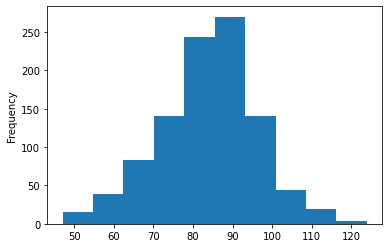

In [13]:
# Plot length of text
df["title"].str.len().plot(kind="hist")


<AxesSubplot:ylabel='Frequency'>

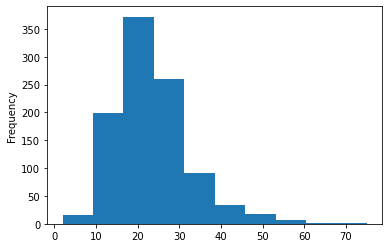

In [15]:

count_sentences(df["text"]).plot(kind="hist")

In [7]:
import spacy



def create_sentencizer() -> spacy.pipeline.Sentencizer:
    """
    Creates a sentencizer pipe.
    """
    nlp = spacy.load("en_core_web_sm")
    nlp.disable_pipes('tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner')
    nlp.add_pipe("sentencizer")
    return nlp
def count_sents(text: str, sentencizer) -> int:
    """
    Counts the number of sentences in a text.
    """
    doc = sentencizer(text)
    return sum(1 for _ in doc.sents)


sentencizer = create_sentencizer()

first_n_sentences(df["text"][0], 3, sentencizer)

#num_sents = df["text"].apply(lambda x: count_sents(x, sentencizer))

'Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it.'

In [49]:
%%ipytest


def test_first_n_sentences():
    text = "This is a sentence. This is another sentence. This is the last sentence."
    assert first_n_sentences(text, 2, sentencizer) == "This is a sentence. This is another sentence."
    assert first_n_sentences(text, 1, sentencizer) == "This is a sentence."
def test_first_n_empty():
    text = "this is the only sentence"
    assert first_n_sentences(text, 2, sentencizer) == text

..                                                                                           [100%]
2 passed in 0.04s


In [9]:
df["short_text"] = df["text"].apply(lambda x: first_n_sentences(x, 2, sentencizer))

In [10]:
df["short_text"].head().to_list()

['Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.',
 'House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump.',
 'On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own. In January, there was a brief run-in on a plane between Clarke and fellow passenger Dan Black, who he later had detained by the police for no reason whatsoever, except that maybe his feelings were hurt.',
 'On Christmas day, Donald Trump announced that he would  be back to work  the following day, but he is go

Index(['title', 'text', 'subject', 'date', 'short_text'], dtype='object')

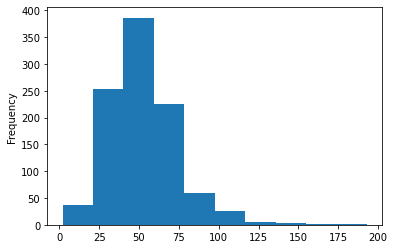

In [14]:
# count number of words per string in df["short_text"]
df["short_text"].str.split().str.len().plot(kind="hist")

long_texts = df[df["short_text"].str.split().str.len() > 100]
long_texts.columns

# Exploring prompt generation
- Let's have a look at how to create nice prompts 
- Based on https://6b.eleuther.ai/


In [21]:
df = pd.read_csv("data/clean_news_examples.csv")
df["prompt"] = df["type"].str.lower() + " headline: " + df["title"] + "\n" + "text:"

df["prompt"].str.split(r"\s").str.len()

0     17
1     20
2     16
3     21
4     19
5     18
6     13
7     14
8     16
9     15
10    24
11    16
12    14
13    14
14    17
15    16
16    16
17    16
18    15
19    15
20    13
21    14
22    14
23    15
24    16
25    15
26    11
27    10
28    14
29    14
30    12
31    12
32    14
33    10
34    16
35    16
36    14
37    12
38    13
39    13
Name: prompt, dtype: int64

In [22]:
df[df["short_text"].str.split().str.len() < 80]

,title,subject,date,short_text,type,prompt
0,“This is a big deal!” Obama Lied About ISIS Pr...,Government News,"Sep 20, 2015",Steve Hayes says the biggest scandal yet for O...,Fake,fake headline: “This is a big deal!” Obama Lie...
1,WIKILEAKS JULIAN ASSANGE Says He Has NEW Email...,left-news,"Jul 25, 2016",Julian Assange tells what he ll do next and wh...,Fake,fake headline: WIKILEAKS JULIAN ASSANGE Says H...
2,REINCE PRIEBUS INTERVIEW: Is Speaker Ryan to B...,politics,"Mar 26, 2017",,Fake,fake headline: REINCE PRIEBUS INTERVIEW: Is Sp...
3,No Ex-President In 100 Yrs Has Set Up A Shadow...,politics,"Mar 13, 2017",FOX News Catherine Herridge exposes the dirty...,Fake,fake headline: No Ex-President In 100 Yrs Has ...
4,COLLEGE STUDENT’S UNDERCOVER VIDEO GETS HIM SU...,politics,"Feb 16, 2017",THIS IS OUTRAGEOUS! YOU WON T BELIEVE THIS!,Fake,fake headline: COLLEGE STUDENT’S UNDERCOVER VI...
5,TREY GOWDY BREAKS DOWN What Clinton Hasn’t Ans...,Government News,"Aug 25, 2016",Trey Gowdy rips into the Clinton case of using...,Fake,fake headline: TREY GOWDY BREAKS DOWN What Cli...
6,LAUGHABLE! MAXINE WATERS On Why She Wants To I...,politics,"Jan 16, 2017",,Fake,fake headline: LAUGHABLE! MAXINE WATERS On Why...
7,"BOOM! DONALD TRUMP, JR Wins Best Cruz Comment ...",politics,"Jul 21, 2016",The best unity I saw was everyone booing him ...,Fake,"fake headline: BOOM! DONALD TRUMP, JR Wins Bes..."
8,JUDGE JEANINE ON FIRE: “Paul Ryan Needs to Ste...,politics,"Mar 25, 2017",,Fake,fake headline: JUDGE JEANINE ON FIRE: “Paul Ry...
9,WATCH HUGE CROWD CHEER When Asked If Trump Sho...,politics,"Oct 9, 2016",,Fake,fake headline: WATCH HUGE CROWD CHEER When Ask...


In [65]:
import openai
import json
from pathlib import Path

def read_json(filename: Path) -> dict:
    """
    Reads a json file.
    """
    with open(filename, "r") as f:
        return json.load(f)

def get_api_key(config: Path, keyname: str = "goose_api") -> str:
    """
    Gets the API key from the config file.
    """
    return read_json(config)[keyname]


api_key = get_api_key(Path("config.json"))

# Authenticate OPenai API
openai.api_key = api_key
openai.api_base = "https://api.goose.ai/v1"

modelid = "gpt-neo-125m"



In [63]:
testprompt = df["prompt"][21]
testprompt

"true headline: UK's May says foreign minister Johnson 'doing good work'\ntext:"

In [66]:
myprompt = "Q: what is the meaning of life?\nA:" 
testy = openai.Completion.create(
  engine="gpt-neo-125m",
  prompt=testprompt,
  temperature=0.9,
  max_tokens=75,
)

PermissionError: Your organization does not have enough balance to request this action (need $0.00008, have $0 in active grants, $0 in balance).

In [59]:
answer = testy["choices"][0]["text"]
print(f"{testprompt =}")
print(f"")
print(f"{testprompt + answer =}")

testprompt ='True headline:Venezuelan opposition disarray heaps pain on protesters\ntext:'

testprompt + answer ='True headline:Venezuelan opposition disarray heaps pain on protesters\ntext: \'Unsatisfied with the government\'s response\'\n\nA Reuters journalist in Venezuela\'s capital, Caracas, described the opposition\'s violent demonstrations in a scathing report that came from a military press corps. "Most of the demonstrators are well armed," he wrote in a post that appeared to be taken down.\n\nThe article took up by'


In [60]:
answer

' \'Unsatisfied with the government\'s response\'\n\nA Reuters journalist in Venezuela\'s capital, Caracas, described the opposition\'s violent demonstrations in a scathing report that came from a military press corps. "Most of the demonstrators are well armed," he wrote in a post that appeared to be taken down.\n\nThe article took up by'